# GFL (MMDetection) for AWS Inferentia

This notebook borrows from the official [MMDetection colab tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb). It details the steps required to compile the MMDetection GFL (R-101) model for use on AWS Inferentia.

**Reference:** https://github.com/open-mmlab/mmdetection/blob/master/configs/gfl/README.md

## 1) Install dependencies

Verify that this Jupyter notebook is running the Python kernel environment that was set up according to the [Inf1 PyTorch Installation Guide](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/setup/torch-neuron.html#setup-torch-neuron). You can select the kernel from the 'Kernel -> Change Kernel' option on the top of this Jupyter notebook page.

In [ ]:
!pip install openmim==0.3.1

In [ ]:
!mim install mmcv-full==1.7.0

In [ ]:
import os
if not os.path.isdir('mmdetection'):
    !git clone -b v2.25.2 https://github.com/open-mmlab/mmdetection.git && \
     cd mmdetection && pip install -e .

### 1.1) Download MMDetection GFL checkpoint

In [ ]:
import os
import urllib
model_filename='gfl_r101_fpn_mstrain_2x_coco_20200629_200126-dd12f847.pth'
model_path=f'{model_filename}'
if not os.path.isfile(model_path):
    urllib.request.urlretrieve(
        f'https://download.openmmlab.com/mmdetection/v2.0/gfl/gfl_r101_fpn_mstrain_2x_coco/{model_path}',
        model_path)

## 2) Initialize libraries and prepare input samples

In [ ]:
import torch
import sys
if 'mmdetection' not in sys.path: sys.path.append('mmdetection')
if 'mmdet' not in sys.path: sys.path.append('mmdet')
from mmdet.datasets.pipelines import Compose
from mmdet.apis import init_detector

# Instantiate the model from the pre-trained checkpoint / config
config = 'mmdetection/configs/gfl/gfl_r101_fpn_mstrain_2x_coco.py'

# Use the detector to do inference
img = 'mmdetection/demo/demo.jpg'

## 3) Load a pre-trained model and check if it is .jit traceable
Let's decompose the [inference process](https://github.com/open-mmlab/mmdetection/blob/e876171cdf6cf09cb45fb7e62051365e35fca167/mmdet/apis/inference.py#L90) from the above `inference_detector(model, img)` call in order to remove one layer of abstraction. We do this because we need to understand the required inputs when we attempt to compile the model using Neuron.

In [ ]:
model = init_detector(config, model_path, device='cpu:0')
model.eval()

def make_input(img, model):
    # See: https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L90
    test_pipeline = Compose(model.cfg.data.test.pipeline)
    data = dict(img_info=dict(filename=img), img_prefix=None)
    data = test_pipeline(data)
    data['img_metas'] = [[data['img_metas'][0].data]]
    data['return_loss'] = False
    data['rescale']=True
    x = data['img'][0].data.unsqueeze(0)
    del data['img']
    return data,x
x = make_input(img, model)[1]
print(x.shape)

Through [manual inspection of the GFL model source](https://github.com/open-mmlab/mmdetection/blob/e876171cdf6cf09cb45fb7e62051365e35fca167/mmdet/models/detectors/single_stage.py#L101), you see that at inference time, the input tensor is passed sequentially through `backbone` -> `neck` -> `bbox_head`.

If you omit the subsequent post-processing ([first here](https://github.com/open-mmlab/mmdetection/blob/e876171cdf6cf09cb45fb7e62051365e35fca167/mmdet/models/dense_heads/dense_test_mixins.py#L36) then [here](https://github.com/open-mmlab/mmdetection/blob/e876171cdf6cf09cb45fb7e62051365e35fca167/mmdet/models/detectors/single_stage.py#L105)) for now, you can stack the 3 modules into a single Sequential model, and try to compile it using Neuron.

In [ ]:
import types
import inspect
from mmdet.core import bbox2result
def f(self, img=None, **kwargs):    
    if torch.jit.is_tracing():
        return self.forward_dummy(img)
    elif hasattr(self, 'forward_neuron'):
        out = self.forward_neuron(img)
        # Then do required post-processing via the original bbox_head
        results_list = self.bbox_head.get_bboxes(
            cls_scores=out[0], bbox_preds=out[1], img_metas=kwargs['img_metas'][0], rescale=True)
        return [bbox2result(det_bboxes, det_labels, self.bbox_head.num_classes) for det_bboxes, det_labels in results_list]
    else:        
        if len(kwargs) == 0:            
            kwargs['img_metas'],kwargs['return_loss'],kwargs['rescale'] = [{}],False,True
        return self.forward_([img], **kwargs)

if not hasattr(model, 'forward_'): model.forward_ = model.forward
model.forward = types.MethodType(f, model)

try:
    traced_model = torch.jit.trace(model, x)
    torch.save(inspect.getsource(f), 'model_forward.pt')
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model, example_inputs=x)

In [ ]:
import os
import torch
import torch.neuron

if not os.path.isfile("gfl_neuron.pt"):
    # This takes ~60 minutes on an inf1.6xlarge
    model_neuron = torch.neuron.trace(model, example_inputs=x)

    ## Export to saved model
    model_neuron.save("gfl_neuron.pt")
else:
    model_neuron = torch.load("gfl_neuron.pt")
model.forward_neuron = model_neuron

### 4.1) Verify the optimized model

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## 5) A simple test to check the predictions

load checkpoint from local path: checkpoints/gfl_r101_fpn_mstrain_2x_coco_20200629_200126-dd12f847.pth


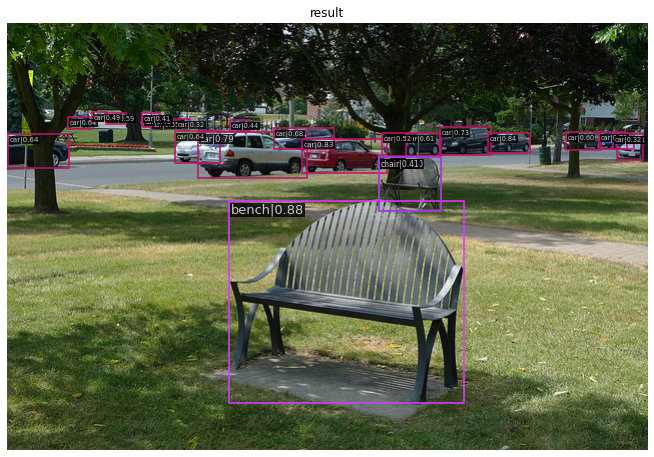

In [8]:
import types
import torch
import torch.neuron
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.apis import init_detector
from mmdet.core import bbox2result

exec(torch.load('model_forward.pt'))
model = init_detector(config, model_path, device='cpu:0')
model.forward_neuron = torch.load('gfl_neuron.pt')
model.forward = types.MethodType(f, model)
model.eval()

data,x = make_input(img, model)

results = model(img=x, **data)
show_result_pyplot(model, img, results[0], score_thr=0.3)